**Parallel**

In [ ]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

In [ ]:
!apt-get install libopencv-dev

In [44]:
%%writefile main.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <dirent.h>
#include <opencv2/opencv.hpp>
#include <sys/time.h>
#include <sys/stat.h>  // For mkdir
#include <sys/types.h> // For mode_t

__global__ void apply_sobel_filter(unsigned char* d_image, unsigned char* output, int width, int height, int threshold) {
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    if (x > 0 && y > 0 && x < width - 1 && y < height - 1) {
        int dx = (-1 * d_image[(y - 1) * width + (x - 1)]) + (-2 * d_image[y * width + (x - 1)]) + (-1 * d_image[(y + 1) * width + (x - 1)]) +
                   (     d_image[(y - 1) * width + (x + 1)]) + ( 2 * d_image[y * width + (x + 1)]) + (     d_image[(y + 1) * width + (x + 1)]);
        int dy = (     d_image[(y - 1) * width + (x - 1)]) + ( 2 * d_image[(y - 1) * width + x]) + (     d_image[(y - 1) * width + (x + 1)]) +
                   (-1 * d_image[(y + 1) * width + (x - 1)]) + (-2 * d_image[(y + 1) * width + x]) + (-1 * d_image[(y + 1) * width + (x + 1)]);
        int magnitude = sqrtf(dx * dx + dy * dy);
        // Apply thresholding
        if (magnitude < threshold) {
            output[y * width + x] = 0;  // Set to zero if below threshold
        } else {
            output[y * width + x] = min(magnitude, 255);  // Otherwise, keep the magnitude value
        }
    }
}

int main(int argc, char** argv) {
    if (argc < 2) {
        fprintf(stderr, "Usage: %s <image_directory>\n", argv[0]);
        return -1;
    }

    const char* datasetPath = argv[1];
    DIR* dir = opendir(datasetPath);
    if (!dir) {
        fprintf(stderr, "Failed to open directory: %s\n", datasetPath);
        return -1;
    }

    struct dirent* entry;
    float gpuTimes[100];
    int imageIndex = 0;

    while ((entry = readdir(dir)) != NULL) {
        if (entry->d_type == DT_REG) {  // Process regular files
            char imagePath[512];
            snprintf(imagePath, sizeof(imagePath), "%s/%s", datasetPath, entry->d_name);

            cv::Mat image = cv::imread(imagePath, cv::IMREAD_GRAYSCALE);
            if (image.empty()) {
                fprintf(stderr, "Failed to load image: %s\n", imagePath);
                continue;
            }

            int width = image.cols;
            int height = image.rows;
            size_t imageSize = width * height * sizeof(unsigned char);

            unsigned char* d_image, *output_d_image;
            cv::Mat output_image(height, width, CV_8UC1);

            // GPU Memory allocation
            cudaMalloc((void**)&d_image, imageSize);
            cudaMalloc((void**)&output_d_image, imageSize);

            // Copy image to device
            cudaMemcpy(d_image, image.data, imageSize, cudaMemcpyHostToDevice);

            // Configure kernel
            dim3 blockDim(16, 16);//1024 default
            dim3 gridDim((width + blockDim.x - 1) / blockDim.x, (height + blockDim.y - 1) / blockDim.y);

            // GPU Timing
            cudaEvent_t start, stop;
            cudaEventCreate(&start);
            cudaEventCreate(&stop);
            cudaEventRecord(start);

            // Launch Sobel kernel
            apply_sobel_filter<<<gridDim, blockDim>>>(d_image, output_d_image, width, height, 120);
            cudaDeviceSynchronize();

            cudaEventRecord(stop);
            cudaEventSynchronize(stop);

            float gpuTime;
            cudaEventElapsedTime(&gpuTime, start, stop);
            gpuTimes[imageIndex] = gpuTime;

            // Copy result back to host
            cudaMemcpy(output_image.data, output_d_image, imageSize, cudaMemcpyDeviceToHost);

            // Free GPU memory
            cudaFree(d_image);
            cudaFree(output_d_image);

            // Save output image
            const char* outputDir = "output_gpu";
            struct stat st = {0};
            if (stat(outputDir, &st) == -1) {
                mkdir(outputDir, 0700); // Create the directory with read/write/execute permissions for the owner
            }
            // Save output image
            char outputPath[512];
            snprintf(outputPath, sizeof(outputPath), "%s/output_%s", outputDir, entry->d_name);
            cv::imwrite(outputPath, output_image);
            printf("Processed: %s -> %s\n", imagePath, outputPath);

            // Clean CUDA events
            cudaEventDestroy(start);
            cudaEventDestroy(stop);

            imageIndex++;
        }
    }
    closedir(dir);

    // Save timing results to a CSV file
    FILE* csvFile = fopen("gpu_processing_times.csv", "w");
    fprintf(csvFile, "image,processing_time\n");
    for (int i = 0; i < imageIndex; i++) {
        fprintf(csvFile, "%d,%.2f\n", i + 1, gpuTimes[i]);
    }
    // Output results
    for (int i = 0; i < imageIndex; i++) {
        printf("Image %d: GPU Time = %.2f ms\n",i + 1, gpuTimes[i]);
    }
    return 0;
}


Overwriting main.cu


In [45]:
!nvcc main.cu -o main `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [46]:
!./main "/kaggle/input/images/dataset"

Processed: /kaggle/input/images/dataset/im2.jpg -> output_gpu/output_im2.jpg
Processed: /kaggle/input/images/dataset/im7.jpg -> output_gpu/output_im7.jpg
Processed: /kaggle/input/images/dataset/im6.jpg -> output_gpu/output_im6.jpg
Processed: /kaggle/input/images/dataset/im9.jpg -> output_gpu/output_im9.jpg
Processed: /kaggle/input/images/dataset/im0.jpg -> output_gpu/output_im0.jpg
Processed: /kaggle/input/images/dataset/im4.jpg -> output_gpu/output_im4.jpg
Processed: /kaggle/input/images/dataset/im8.jpg -> output_gpu/output_im8.jpg
Processed: /kaggle/input/images/dataset/im13.jpg -> output_gpu/output_im13.jpg
Processed: /kaggle/input/images/dataset/im11.jpg -> output_gpu/output_im11.jpg
Processed: /kaggle/input/images/dataset/im1.jpg -> output_gpu/output_im1.jpg
Processed: /kaggle/input/images/dataset/im3.jpg -> output_gpu/output_im3.jpg
Processed: /kaggle/input/images/dataset/im12.jpg -> output_gpu/output_im12.jpg
Processed: /kaggle/input/images/dataset/im10.jpg -> output_gpu/output_

**Sequential**

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import csv

# Sobel filters
gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Convolution function
def convolution(img, kernel):
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2
    output = np.zeros((img.shape[0] - 2 * pad, img.shape[1] - 2 * pad), dtype=np.float32)

    for i in range(pad, img.shape[0] - pad):
        for j in range(pad, img.shape[1] - pad):
            region = img[i - pad:i + pad + 1, j - pad:j + pad + 1]
            output[i - pad, j - pad] = np.sum(region * kernel)
    return output

# Directory path for input images
input_dir = '/kaggle/input/images/dataset'  # Replace with your directory
output_dir = 'output_cpu'

# Create output directory if not exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Results list
results = []

# Process all images in the directory
for index, filename in enumerate(os.listdir(input_dir)):
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
        # Load the image
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Skipping file {filename}, unable to read.")
            continue

        # Start the timer
        start_time = time.time()

        # Apply Sobel filters
        gradient_x = convolution(img, gx)
        gradient_y = convolution(img, gy)

        # Calculate magnitude
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

        threshold = 120
        # Apply thresholding: values below the average are set to 0
        gradient_magnitude[gradient_magnitude < threshold] = 0

        # Stop the timer
        end_time = time.time()

        # Calculate elapsed time
        elapsed_time = end_time - start_time
        print(f"Processed {filename} in {elapsed_time:.6f} seconds")

        # Save the result image
        output_path = os.path.join(output_dir, f'output_{filename}')
        cv2.imwrite(output_path, gradient_magnitude.astype(np.uint8))

        # Append to results
        results.append({
            "image": index,
            "processing_time": elapsed_time
        })

# Save results to CSV
csv_path = "cpu_processing_times.csv"
with open(csv_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["image", "processing_time"])
    writer.writeheader()
    writer.writerows(results)

print(f"Processing times saved to {csv_path}.")


Processed im2.jpg in 12.441714 seconds
Processed im7.jpg in 13.700337 seconds
Processed im6.jpg in 14.259171 seconds
Processed im9.jpg in 12.575814 seconds
Processed im0.jpg in 18.627394 seconds
Processed im4.jpg in 4.039689 seconds
Processed im8.jpg in 12.590515 seconds
Processed im13.jpg in 3.455545 seconds
Processed im11.jpg in 4.264601 seconds
Processed im1.jpg in 12.007447 seconds
Processed im3.jpg in 12.565002 seconds
Processed im12.jpg in 3.063388 seconds
Processed im10.jpg in 3.084545 seconds
Processed im5.jpg in 12.844474 seconds
Processing times saved to cpu_processing_times.csv.


**Plot**

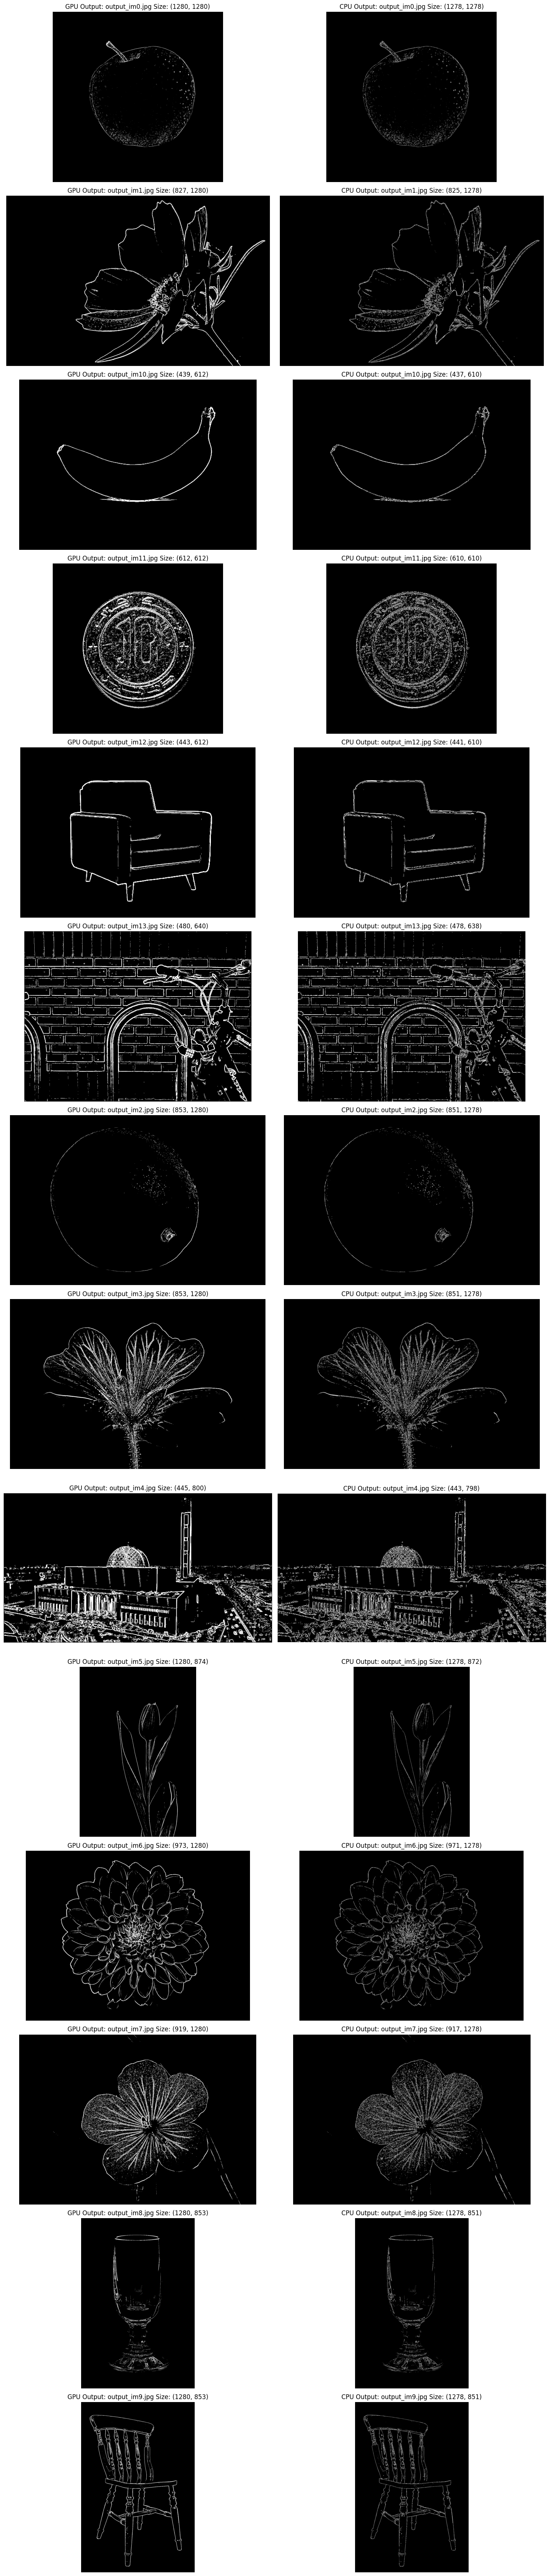

In [50]:
import cv2
import os
import matplotlib.pyplot as plt

# Define directories
gpu_output_dir = "output_gpu"
cpu_output_dir = "output_cpu"

# Function to filter out unwanted files
def get_image_files(directory):
    return sorted(
        [f for f in os.listdir(directory) if not f.startswith(".") and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    )

# Get the list of images in both directories
gpu_images = get_image_files(gpu_output_dir)
cpu_images = get_image_files(cpu_output_dir)

# Ensure the directories have the same number of images
assert len(gpu_images) == len(cpu_images), "Mismatch in the number of images!"

# Display images side by side
plt.figure(figsize=(15, len(gpu_images) * 5))

for i, (gpu_image_name, cpu_image_name) in enumerate(zip(gpu_images, cpu_images)):
    # Load images
    gpu_image_path = os.path.join(gpu_output_dir, gpu_image_name)
    cpu_image_path = os.path.join(cpu_output_dir, cpu_image_name)

    gpu_image = cv2.imread(gpu_image_path, cv2.IMREAD_GRAYSCALE)
    cpu_image = cv2.imread(cpu_image_path, cv2.IMREAD_GRAYSCALE)

    # Add GPU image
    plt.subplot(len(gpu_images), 2, i * 2 + 1)
    plt.imshow(gpu_image, cmap='gray')
    plt.title(f"GPU Output: {gpu_image_name} Size: {gpu_image.shape}")
    plt.axis('off')

    # Add CPU image
    plt.subplot(len(gpu_images), 2, i * 2 + 2)
    plt.imshow(cpu_image, cmap='gray')
    plt.title(f"CPU Output: {cpu_image_name} Size: {cpu_image.shape}")
    plt.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()


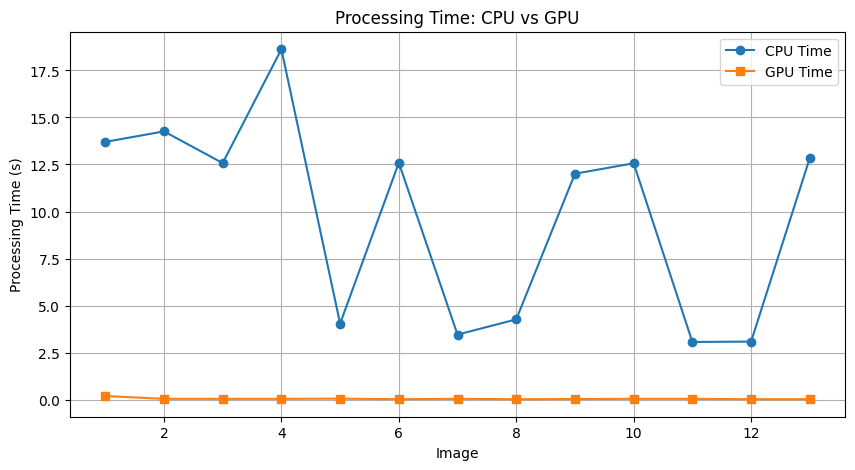

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
cpu_times = pd.read_csv('cpu_processing_times.csv')
gpu_times = pd.read_csv('gpu_processing_times.csv')

# Merge the data for easier comparison
data = pd.merge(cpu_times, gpu_times, on="image", suffixes=('_cpu', '_gpu'))

# Plot processing times
plt.figure(figsize=(10, 5))
plt.plot(data['image'], data['processing_time_cpu'], label='CPU Time', marker='o')
plt.plot(data['image'], data['processing_time_gpu'], label='GPU Time', marker='s')
plt.xlabel('Image')
plt.ylabel('Processing Time (s)')
plt.title('Processing Time: CPU vs GPU')
plt.legend()
plt.grid(True)
plt.show()